# The Efficient Frontier of Philanthropy

The concept of an [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for investment portfolios originated with Harry Markowitz's [Modern Portfolio Theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory).  Markowitz's main insight was that you can minimize the risk you take for any level of return by diversifying a portfolio.  The end result is a hyperbola, often called the Markowitz Bullet, that demonstrates that greater returns are associated with higher risk.  Although this approach to porfolio optimization is less popular today, modified versions of MPT still underly many robo-advisors on the market today ([Wealthfront](http://www.slideshare.net/wealthfront/engineering-your-portfolio-with-etfs/35-Want_us_to_do_this), [WiseBanyan](https://wisebanyan.com/investment-strategy), [Betterment](https://www.betterment.com/portfolio/)). 

![frontier image](https://upload.wikimedia.org/wikipedia/commons/e/e1/Markowitz_frontier.jpg)  

The following code implements this concept in Python, and is based on a [blog post](http://blog.quantopian.com/markowitz-portfolio-optimization-2/) from Quantopian.  Their original code returns an optimal portfolio for any given level of risk when given a list of historic returns for a group of assets.  I then extend the concept of an efficient frontier to the area charitable giving, and refactor the code to take a list of charitable returns (in DALYs) and a covariance matrix as an input.  The final output is a philanthropic efficient frontier.  

The following is a rough sketch of my concept, feel free to critique and contribute!

### Traditional Investment Example: 

In [36]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

import mpld3
from mpld3 import plugins

mpld3.enable_notebook()


np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000  #original 1000

#results in a n_assets x n_obs vector, with a return for each asset in each observed period
return_vec = np.random.randn(n_assets, n_obs) 



def convert_portfolios(portfolios):
    ''' Takes in a cvxopt matrix of portfolios, returns a list of portfolios '''
    port_list = []
    for portfolio in portfolios:
        temp = np.array(portfolio).T
        port_list.append(temp[0].tolist())
        
    return port_list


def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))  
    
    #S is the covariance matrix,  
    # diagonal is the variance of each stock:
    #[ 1.00e+00 -3.00e-02 -3.19e-02 -2.72e-02]
    #[-3.00e-02  9.19e-01 -1.26e-02 -3.74e-02]
    #[-3.19e-02 -1.26e-02  9.64e-01  6.39e-03]
    #[-2.72e-02 -3.74e-02  6.39e-03  9.79e-01]
    
    
    pbar = opt.matrix(np.mean(returns, axis=1))     #pbar is the mean return of each stock

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] #returns a list of objects
                  for mu in mus]

    port_list = convert_portfolios(portfolios)
    
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] #np.sqrt returns the stdev, not variance
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    #print m1 # result: [ 159.38531535   -3.32476303    0.4910851 ]
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x'] #Is this the tangency portfolio? X1 = slope from origin?  

    return np.asarray(wt), returns, risks, port_list


weights, returns, risks, portfolios = optimal_portfolio(return_vec)

<IPython.core.display.Javascript object>


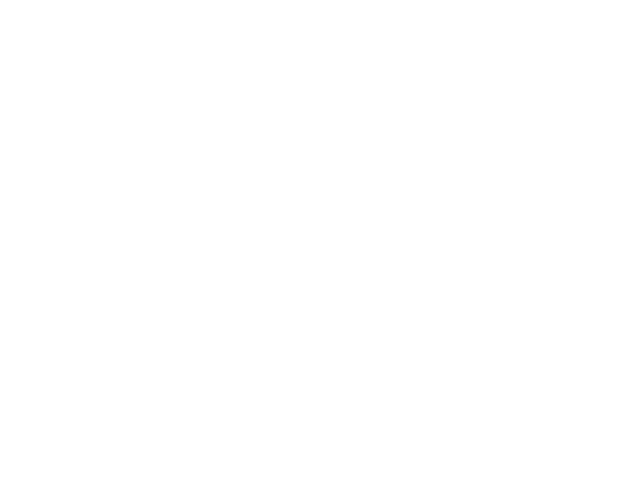

In [37]:
# Matplotlib only plot: 
#plt.ylabel('mean')
#plt.xlabel('std')
#plt.plot(risks, returns, 'y-o') #risks and returns are just arrays of points along the frontier
#plt.show()


# Interactive plot using mpld3:
def interactive_plot(risks, returns, portfolios):
    fig, ax = plt.subplots()
    ax.grid(True, alpha=0.3)


    labels = []
    for i in range(len(risks)):
        label = " Risk: " + str(risks[i]) + " Return: " + str(returns[i]) + " Portfolio Weights: " + str(portfolios[i])
        labels.append(str(label))

    points = ax.plot(risks, returns, 'y-o', color='b',
                     mec='k', ms=15, mew=1, alpha=.6)

    ax.set_xlabel('standard deviation')
    ax.set_ylabel('return')
    ax.set_title('Efficient Frontier', size=20)

    tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10)
    plugins.connect(fig, tooltip)

    return mpld3.display()

#Note: if you're in the IPython notebook, mpld3.show() is not the best command
#      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
#      See more information at http://mpld3.github.io/quickstart.html.
    
interactive_plot(risks, returns, portfolios)

# Application to Philanthropy

An interesting next question is, does this same type of risk return relationship apply to philanthropy?  Are areas with highly uncertain yet historically high returns like scientific research the best place to put philanthropic money?  I outline a framework that might help answer this question below.    

The above code is great if you have a well curated list of historical returns for different stocks, but the same isn't true for the world of philanthropy.  Very few charities or philanthropic endeavors have good data on how their interventions impact the world.  And even if a charity does have good data on their impact, it is still very hard to compare effectiveness *across* interventions.  

One method that healthcare economists have developed to compare across interventions is the [Disability Adjusted Life Year](https://en.wikipedia.org/wiki/Disability-adjusted_life_year), or DALY.  A measure that determines the cost effectiviness of an intervention is the \$/DALY, which can be though of as the "return" to charitable giving.  Economists will often perform sensitivity analysis when calculating \$/DALY values, which result in a variance or standard deviation for their estimates.  The \$/DALY metric, combined with the variance from the sensitivity analyses give us all the information we need to create an efficient frontier that combines different interventions.      

Next, I refactor the above code to take covariance and mean return matrices as inputs instead of historical returns.  This would allow anyone who has done a cost effectiveness analysis along with a sensitivity analysis to input their values as lists, and output an efficient frontier.    

In [38]:
def covmean_portfolio(covariances, mean_returns):
    ''' Returns an optimal portfolio given a covariance matrix and matrix of mean returns '''
    n = len(mean_returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]


    S = opt.matrix(covariances)  # convert array to matrix  

    pbar = opt.matrix(mean_returns)  # convert array to matrix

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    #Convert portfolios to list for output
    port_list = convert_portfolios(portfolios)
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    frontier_returns = [blas.dot(pbar, x) for x in portfolios]  #differ from those input, renamed
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] #np.sqrt returns the stdev, not variance
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(frontier_returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']   

    return np.asarray(wt), frontier_returns, risks, port_list


### Basic Application

Next, I create a simple list of variances and covariances, assuming there are no covariances between charities.  The covariances is a list of lists, with each sub-list representing a column in the covariance matrix.  The diagonal of this matrix represents the variances for individual interventions.  The mean returns list just contains the estimate for the mean impact in DALYs.  In the future, it might be possible to incorporate positive externalities, or flow-through effects in this matrix by including them as covariances between interventions (although covariances aren't causative or directional).  In this case, I assumed each intervention has a variance of 1, and chose a few mean returns.   

<IPython.core.display.Javascript object>


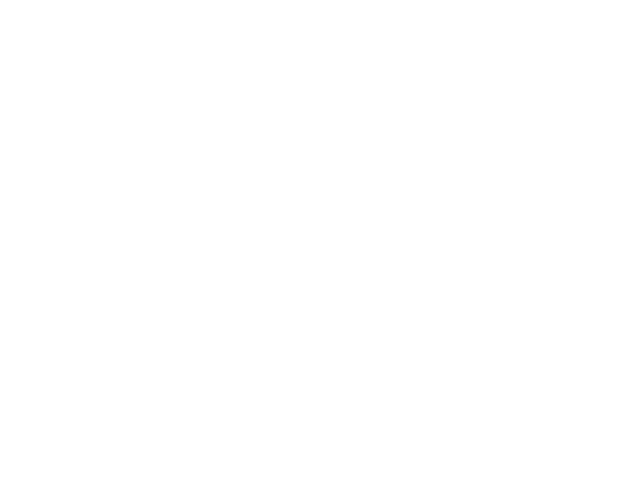

In [35]:
# Sub-lists represent matrix columns, diagonal is the variance of each intervention
covariances = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]] 

mean_returns = [1.2,5.0,3.0,1.5]

weights, returns, risks, portfolios = covmean_portfolio(covariances, mean_returns)


interactive_plot(risks, returns, portfolios)


# Model Shortcomings


- Markowitz's version of Modern Portfolio Theory (MPT) assumes past performance is indicative of the future returns.  Similarly, if the user of this model inputs an average return to an intervention, this does not take into account the declining marginal returns to doing good in the world (e.g. as more money is poured into scientific research, it might become harder to make transformative discoveries).  A person could avoid this problem by only using marginal cost effectiveness estimates, and regularly updating them or using a decay function based on society's investments.

- MPT is usually limited to publicly traded assets with a long history of returns. It is hard to include returns from private equity or real estate in this type of analysis.  High risk philanthropic endeavors might be more analogous to venture capital investments, so MPT might not be the best model to use.     

- Using the standard deviation assumes a normal distribution.  There are versions of MPT that use other distributions that might be useful here.  

- There is very little reason to be risk averse when it comes to philanthropy because we shouldn't care if the returns accrue to us.  Someone else benefits, so why not take the riskiest option with the highest expected value? 

A more complete list of criticisms to Modern Portfolio Theory is available [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory#Criticisms).

# Conclusion

This approach might be a useful way to come up with an optimal portfolio for charitable giving.  This allows us to not only combine \$/DALY measures, but also account for the uncertainty involved in imperfect estimates.  The next step for this analysis is to find a real world dataset that incorporates both \$/DALY estimates along with sensitivity analyses.  I theorize that this dataset whould show that there are returns to risk taking in charitable giving, which would be demonstrated by an upward sloping efficient frontier.  

The DALY is an imperfect measure, as there are some things that are very hard to quantify, but it is still a worthwhile exercise to try to come up with back of the envelope calculations to partially inform the decision making process.  Note that this approach isn't necessarily tied to the \$/DALY, as any cross-intervention measure of social return could be used.  In some cases back of the envelope calculations could actually harm our judgement by giving us a false sense of certainty.  One way to guard against this risk is to only use this as a part of the decision making process, rather than relying solely on this type of analysis.   


## Next Steps

### Real Datasets

Although the above example shows a theoretical upward slope between risk and return, it should be possible to use a few existing datasets to find if this relationship holds in reality.  

Here are some potential data sets to test this theory:

- Disease Control Priorities Project ([DCP2](http://dcp-3.org/dcp2/chapters)): This project took a very comprehensive look at the global disease burden, and provided \$/DALY [estimates](http://dcp-3.org/sites/default/files/dcp2/DCP02.pdf) for a broad variety of diseases in the developing world.  Unfortunately, the estimates don't include sensitivity analyses, and mostly just include a range of point estimates.  I could use the spread of the point estimates from their dataset, but the downside of this is that the interventions with very few estimates would automatically have the lowest variance. 

- The Copenhagen Consensus:  [The Copenhagen Consensus](http://www.copenhagenconsensus.com/) performs cost benefit analyses for a broad variety of health and policy interventions.  They convert everything into monetary cost benefit ratios terms by putting a value on a human life rather than use the \$/DALY.  It would be possible to plot the standard deviation of their estimates against the cost benefit ratio to create an efficient frontier.  However, they do not seem to publish a dataset including both cost benefit ratios and sensitivity analyses.  Their approach relies heavily on expert judgmement as well, which might not be quantifiable.  Converting everything into monetary terms also has the downside of valuing present lives over future lives because future cash flows are discounted.     

- [AidGrade](http://www.aidgrade.org/):  This organization performs meta-analyses that combine the treatment effects of most of the known randomized control trials in the development economics literature.  This [presentation](http://evavivalt.com/2015/09/effective-altruism-talk) by Eva Vivalt outlines the initial results, with treatment effects in standard deviations.  In this case, you could plot standard deviation in treatment effect against the mean treatment effect, as she does in the presentation.  This might give you an idea of the curve shape, although these values should be converted to a cost effectiveness figure like \$/DALY that can be compared across studies.     

- Crowdsourcing: People could submit and discuss cost effectiveness estimates and critique them publicly.  GitHub might be a good venue for these open source cost effectiveness conversations.  

### Black-Litterman Model

The [Black-Litterman model](https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model) generates the expected returns of different assets based on the market's current equilibrium asset allocation rather than using thier historical returns.  This concept could potentially be applied to society's entire allocation of money via markets, governments and philanthropy.  This approach would incorporate the entirety of society's wisdom into a philanthropic portfolio.  Unfortunately, a covariance matrix is still necessary to use this model, and I'm not sure if that would even makes sense to compute.  This is kind of an off-the-wall idea, but I might make a post about it in the future.    
